In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

### Check for and handle missing values.

In [3]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [4]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [7]:
# Check for duplicates
data.duplicated().sum()
# There does not seem to be any duplicates.

0

### Handle outliers

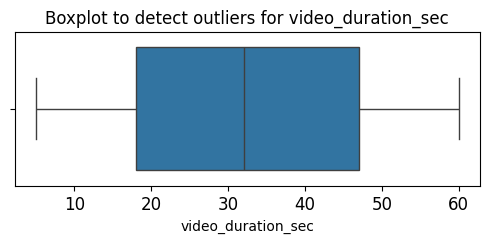

In [8]:
# Create a boxplot to visualize distribution of `video_duration_sec`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_duration_sec', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_duration_sec'])
plt.show()

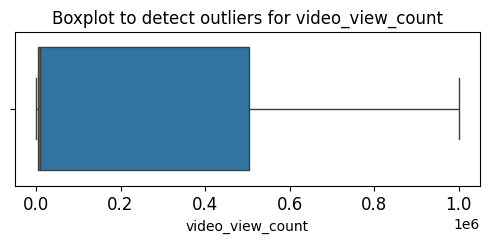

In [9]:
# Create a boxplot to visualize distribution of `video_view_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_view_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_view_count'])
plt.show()

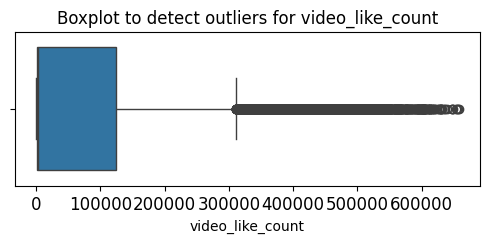

In [10]:
# Create a boxplot to visualize distribution of `video_like_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_like_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_like_count'])
plt.show()

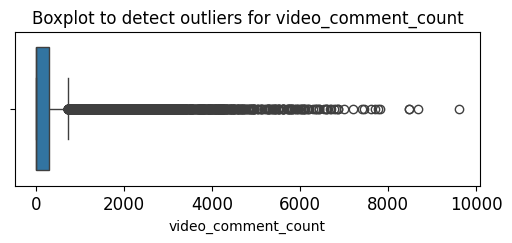

In [11]:
# Create a boxplot to visualize distribution of `video_comment_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_comment_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_comment_count'])
plt.show()

In [12]:
# Check for and handle outliers

percentile25 = data["video_like_count"].quantile(0.25)
percentile75 = data["video_like_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_like_count"] > upper_limit, "video_like_count"] = upper_limit

In [13]:
# Check for and handle outliers

percentile25 = data["video_comment_count"].quantile(0.25)
percentile75 = data["video_comment_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_comment_count"] > upper_limit, "video_comment_count"] = upper_limit

In [14]:
# Check class balance
data["verified_status"].value_counts(normalize=True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

Approximately 93.7% of the dataset represents videos posted by unverified accounts and 6.3% represents videos posted by verified accounts. So the outcome variable is not very balanced.

In [15]:
# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

In [17]:
# Get the average `video_transcription_text` length for claims and the average `video_transcription_text` length for opinions
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


In [20]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


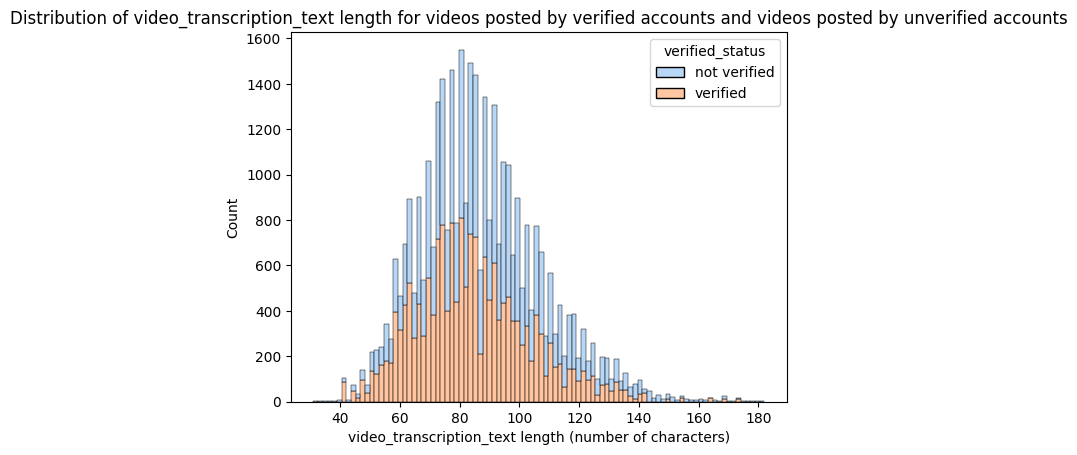

In [21]:
# Visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
# Create two histograms in one plot
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", 
             hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

### Examine correlations

In [25]:
# Code a correlation matrix to help determine most correlated variables
data_upsampled.corr()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.217661
text_length,-0.193677,-0.007083,-0.002981,0.244693,0.216693,0.171651,0.173396,0.217661,1.000000


In [ ]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

### Modeling


In [27]:
# Select outcome variable
y = data_upsampled["verified_status"]

In [29]:
# Select features
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]


In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [31]:
# Check data types
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [32]:
# Get unique values in `claim_status`
X_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [33]:
# Get unique values in `author_ban_status`
X_train["author_ban_status"].unique()

array(['active', 'under review', 'banned'], dtype=object)

In [34]:
# Select the training features that needs to be encoded
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]

# Display first few rows
X_train_to_encode.head()

,claim_status,author_ban_status
33058,opinion,active
20491,opinion,active
25583,opinion,active
18474,opinion,active
27312,opinion,active


In [36]:
# Set up an encoder for one-hot encoding the categorical features
X_encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the training features using the encoder
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)

In [38]:
# Get feature names from encoder
X_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [39]:
# Display first few rows of encoded training features
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])